In [3]:
import pandas as pd
import tensorflow as tf
import numpy as np
import json
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.image as img

In [4]:
df = pd.read_csv("wrong_prediction.csv")

def remove(s:str) -> None:
    return s[16::]


class_labels = json.load(open('CWOX-1-main/CWOX/imagenet_class_index.json', 'r'))

# folder : nums_label
folder_to_nums = {class_labels[key][0]: key for key in class_labels.keys()}

In [11]:
model = tf.keras.applications.inception_v3.InceptionV3(weights='imagenet')

model.compile(loss='categorical_crossentropy', metrics=['acc'])

grad_model = tf.keras.models.Model(
    [model.inputs], [model.get_layer("mixed10").output, model.output]
)

#######Process############
def process(x):
    # i = tf.keras.layers.Input(x, dtype = tf.uint8)
    x = tf.cast(x, tf.float32)
    x = tf.keras.applications.inception_v3.preprocess_input(x)
    x = np.expand_dims(x, axis=0)
    return x

In [69]:
def make_gradcam_heatmap(img_array, grad_model, pred_index):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        # if pred_index is None:
        #     pred_index = tf.argmax(preds[0])

        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def save_and_display_gradcam(img_path, heatmap, cam_path):

    # plt.figure(figsize=[12,8],dpi=200)
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)
    jet_heatmap = jet_heatmap / 255
    
    threshold = np.max(jet_heatmap) * 0.5
    img[jet_heatmap[:,:,0] < threshold] = 0
    return tf.keras.preprocessing.image.array_to_img(img)

    # Superimpose the heatmap on original image
    superimposed_img_array = img + jet_heatmap * 0.3

    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img_array)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    # display(Image(cam_path))

    # return superimposed_img_array

def transform_gradcam(img_path,processed_img_array, grad_model, pred_index,cam_path):
    
    heatmap = make_gradcam_heatmap(processed_img_array, grad_model,pred_index)

    save_and_display_gradcam(img_path, heatmap,cam_path)

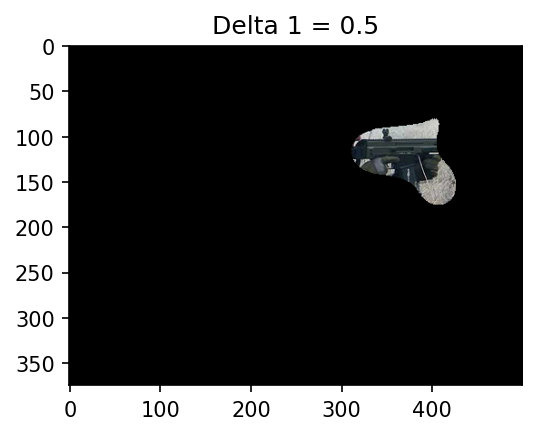

In [70]:
for i in [2680]:
    path = remove(df.iloc[i]['Path'])
    
    image = tf.keras.preprocessing.image.load_img(path, target_size=(299,299))
            
    img_array = tf.keras.preprocessing.image.img_to_array(image)
    
    true = int(folder_to_nums[df.iloc[i]['Category']])
    
    x = process(img_array)

    y = model.predict(x)
    
    pred = np.argmax(y)
    

    heatmap = make_gradcam_heatmap(x, grad_model,true)
    grad = save_and_display_gradcam(path, heatmap,None)
    
    plt.figure(figsize = [4,3],dpi=150)
    plt.imshow(grad)
    plt.title("Delta 1 = 0.5")
    break

#### Examine on validation set

In [20]:
true_path, wrong_path, conf = [],[],[]

for i in range(df.shape[0]):
    path = remove(df.iloc[i]['Path'])
    
    image = tf.keras.preprocessing.image.load_img(path, target_size=(299,299))
            
    img_array = tf.keras.preprocessing.image.img_to_array(image)
    
    true = int(folder_to_nums[df.iloc[i]['Category']])
    
    x = process(img_array)

    y = model.predict(x)
    
    pred = np.argmax(y)
    
    if true == pred:
        continue
    else:
        
        confidence = y[0,pred]
        
        tp = "wrong_gradcam/{}_GroundTruth_{}_{}_{}.png".format(path.split('/')[2].split('.')[0],
                                                                          class_labels[str(true)][1],
                                                                          class_labels[str(pred)][1],
                                                                          str(round(confidence * 100)))
        
        wp = "wrong_gradcam/{}_WrongPred_{}_{}_{}.png".format(path.split('/')[2].split('.')[0],
                                                                           class_labels[str(true)][1],
                                                                          class_labels[str(pred)][1],
                                                                          str(round(confidence * 100)))
        
        transform_gradcam(path,x,grad_model,true,tp)
        
        transform_gradcam(path,x,grad_model,pred,wp)
        
        true_path.append(tp)
        wrong_path.append(wp)
        conf.append(confidence)
        
        
df1 = pd.DataFrame({"True_Path":true_path,"Wrong_Path":wrong_path,"Confidence":conf})
df1.head()

In [ ]:
# df1.to_csv("True_Wrong_Conf.csv",index = None)

In [5]:
df1 = pd.read_csv("True_Wrong_Conf.csv")

### Plot confidence distribution

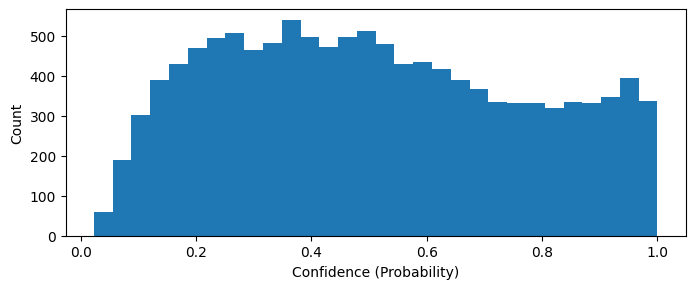

In [44]:
plt.figure(figsize = [8,3], dpi = 100)
plt.hist(df1['Confidence'],bins = 30);
plt.xlabel('Confidence (Probability)')
plt.ylabel('Count');

#### Three types of Errors

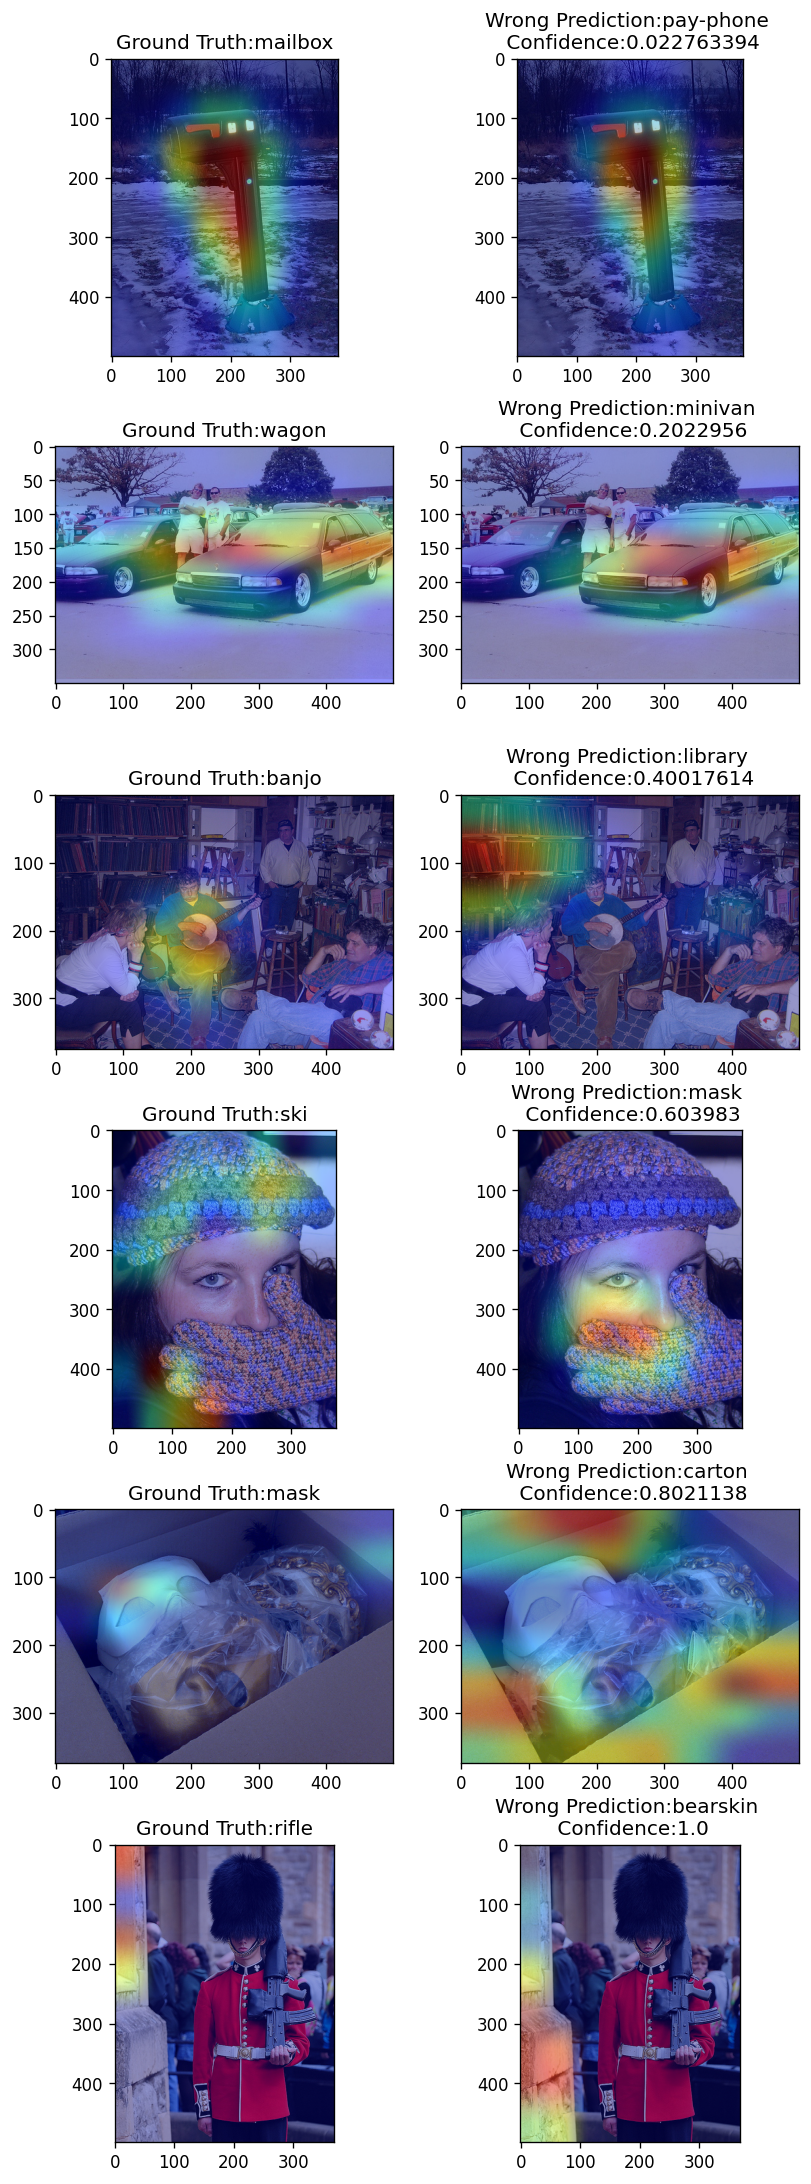

In [8]:
plt.figure(figsize = [8,23], dpi = 120)
index = 1
for val in [0.022763394,0.2022956,0.40017614,0.603983,0.8021138,1.0]:
    
    tp = df1[df1['Confidence'] == val]['True_Path'].tolist()[0]
    image = img.imread(tp)
    plt.subplot(6,2,index)
    plt.imshow(image)
    plt.title("Ground Truth:{}".format(tp.split('_')[-3]))
    index += 1
    
    fp = df1[df1['Confidence'] == val]['Wrong_Path'].tolist()[0]
    image = img.imread(fp)
    plt.subplot(6,2,index)
    plt.imshow(image)
    plt.title("Wrong Prediction:{} \n Confidence:{}".format(tp.split('_')[-2],str(val)))
    index += 1
plt.savefig("wrong_gradcam_compare.png",dpi=200)

#### Plot misclassification pairs (GroundTruth, Wrong Prediction)

In [9]:
from collections import defaultdict

pair = defaultdict(int) 
for i in range(df1.shape[0]):
    pair['_'.join(df1.iloc[i]['True_Path'].split('_')[-3:-1])] += 1
pair = sorted(pair.items(),key = lambda x:x[1],reverse = True)
print("Number of Wrong Prediction: ", len(df))
print("Number of Different Pairs: ", len(pair))

Number of Wrong Prediction:  11862
Number of Different Pairs:  5036


Text(0.5, 1.0, 'Most of misclassification pairs are rare')

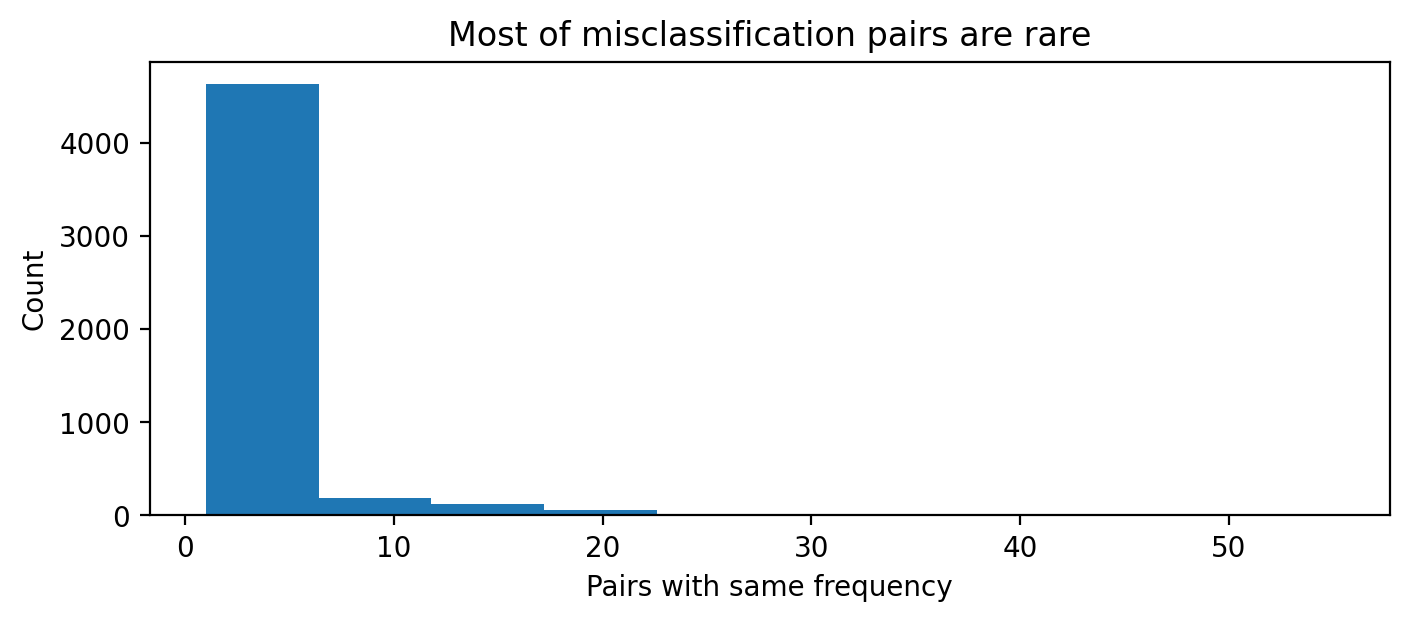

In [96]:
import seaborn as sns
plt.figure(figsize = [8,3], dpi = 200)
plt.hist([i[1] for i in pair],bins = 10);
plt.xlabel("Pairs with same frequency");
plt.ylabel("Count");
plt.title("Most of misclassification pairs are rare")

In [10]:
plt.figure(figsize = [12,3], dpi = 1500)
plt.bar([i[0] for i in pair[0:20]],[i[1] for i in pair[0:20]])
plt.xticks(rotation = 70);
plt.ylabel('Count');
plt.title("Top-20 misclassifacion pairs")
plt.savefig("Top-20_misclassification.png",dpi=200)

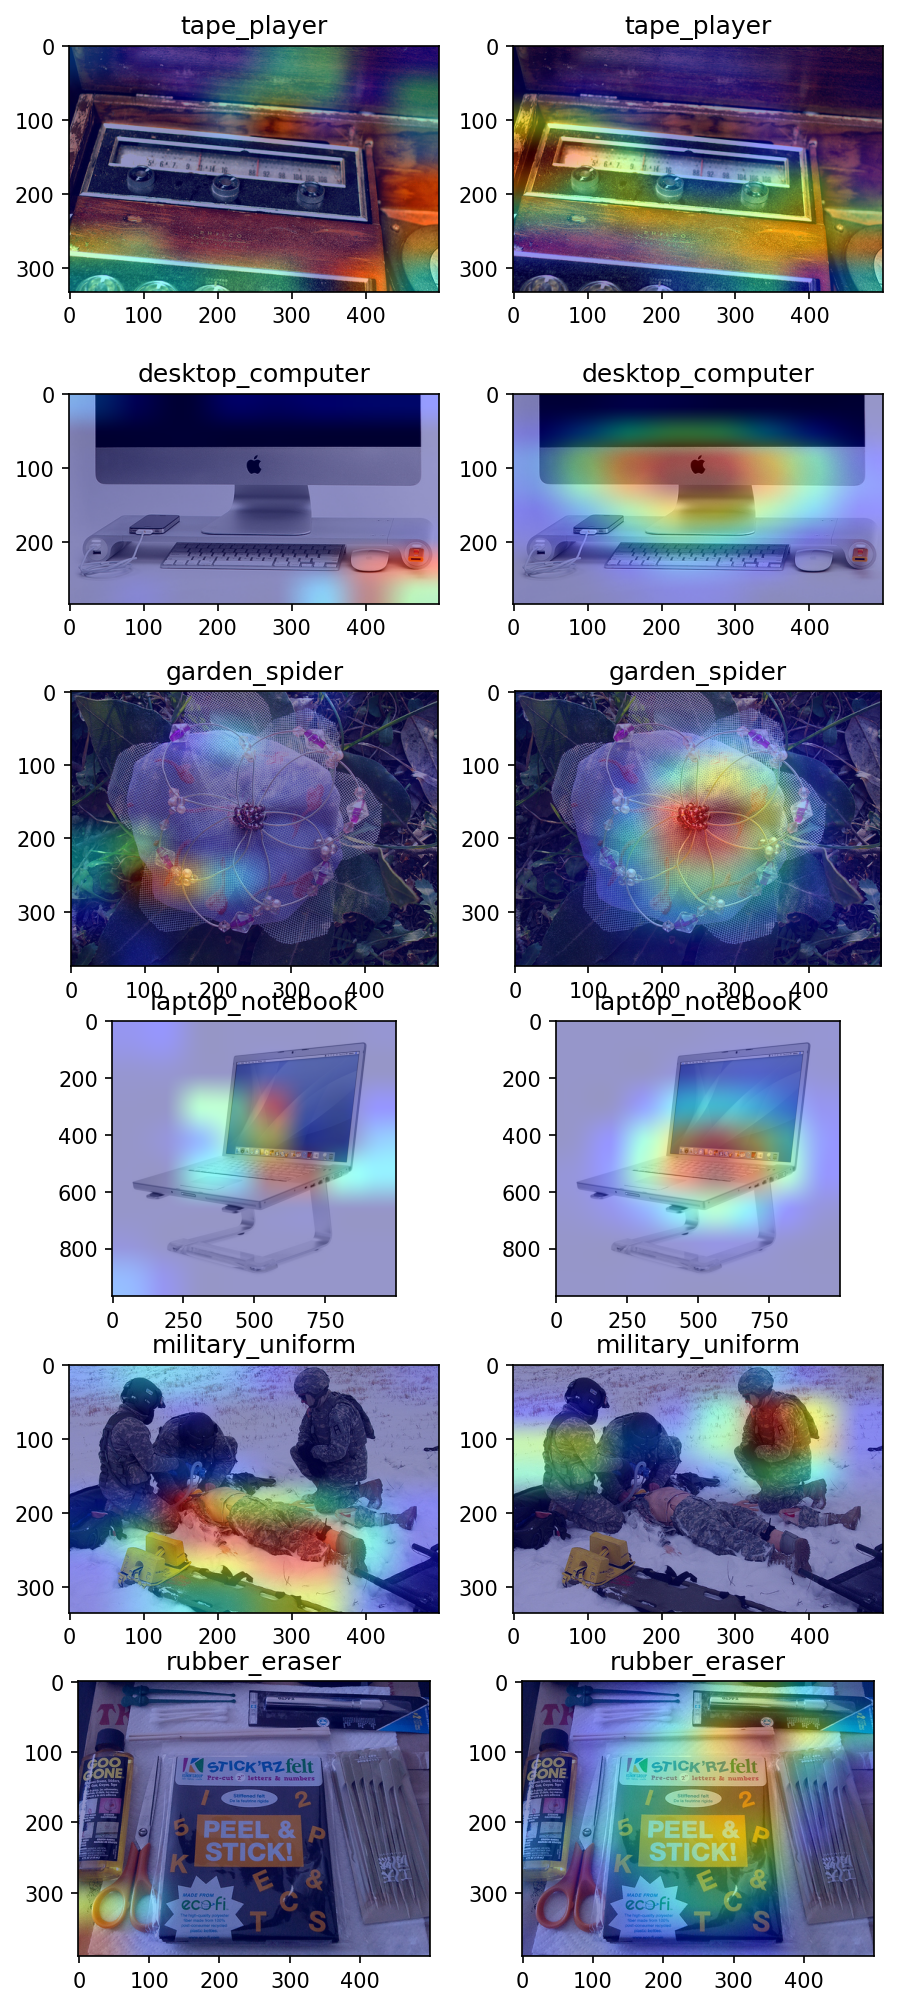

In [138]:
plt.figure(figsize = [7,17], dpi = 150)
index = 1
for i in ["tape_player","desktop_computer","garden_spider","laptop_notebook","military_uniform","rubber_eraser"]:
 
    for j in range(len(df1)):
        if i in df1.iloc[j]['True_Path']:
            image = img.imread(df1.iloc[j]['True_Path'])
            plt.subplot(6,2,index)
            plt.imshow(image)
            plt.title(i)
            
            index += 1
            image = img.imread(df1.iloc[j]['Wrong_Path'])
            plt.subplot(6,2,index)
            plt.imshow(image)
            plt.title(i)
            index += 1

            break
            

#### Summary
- Type I Error, True GroundTruth Attention, Wrong Prediction Attention (Largest Proportion)

- Type II Error, Wrong GroundTruth Attention, True Prediction Attention (Mislabled issue, Few examples)

- Type III Error, Both GroundTruth Attention and Wrong Prediction Attention are True (Class Co-occurence, Second Largest Proportion)

- Type IV Error, Both GroundTruth Attention and Wrong Prediction Attention are Wrong (Impossible to solve, Rare)

We should mainly Focus on Type I & Type III Error

##### Confidence here refers to the probability of predicted class (which is always wrong here!)

- Low confidence related to Correct prediction attention (but predict similar classes, See Fig 1 & 2)

- High confidence related to Wrong attention (See Fig 3.4.5)

- But Sometimes True attention is also Wrong (See Last Fig.)

### Idea in Pseudo-Code

In [ ]:
if GroundTruth Attention is True:
    
    if Prediction is True:  
        skip
        
    else: # Prediction is wrong
    
        if Prediction Attention is similar to GroundTruth Attention: # Type III Error
            
            Error due to similar classes. Hard To solve.
            
        else Prediction Attention is different to GroundTruth Attention: #Type I Error
            
            **Use XGIR to Fix the Prediction Attention to GroundTruth Attention (What XGIR Should do)
            
else The Ground Truth Attention is Wrong :
    
    if Prediction is True:
        
        The Model has Good Luck, we ignore it, skip 
    
    else: # Prediction is Wrong
        
        if Prediction Attention is similar to GroundTruth Attention: # Type IV Error
            
            ** The Model learn wrong attention because of GroundTruth 
            
            ** Very Hard to Solve
        
        else Prediction Attention is different to GroundTruth Attention: #Type II Error
            (Which mean Prediction Attention is Correct)
        
            if extra knowledge is allowed:
            
                Use Top Voted Label to replace groundtruth label
            
            if extra knowledge is not allowed:
                
                Delete this example from trainingset
            
            

#### Problem: 
-    There is no way to know the True Attention Location in ImageNet Data (Unlike Object Detection Dataset)
-    How to measure the difference of the location of GroundTruth Attention and Wrong Prediction Attention? 

#### 1. Presume that (As we previously did)
-    examples with low C-perplexity always have Correct GroundTruth Attention

-    examples with high C-perplexity always have Wrong GroundTruth Attention

#### 2. Introduce some tools to measure the difference

#### Anthony's idea: Cosine Similarity -> Matrix Distance

- I plot the scatter plot 1 (between cosine similarity of e_p and e_t & wrong prediciton confidence) and scatter plot 2 (between cosine similarity of e_p and e_t & C-perplexity), and found that both of two plots show no linear correlation. Thus, pure cosine similarity may not be a good measure of the difference between e_p and e_t

- Thus, I use distance metrics to measure the difference. First, compute the e_p and e_t as usual, and use grayscale to reduce the shape of Gradcam from (H,W,3) to (H,W,1). THen, a threshold is set to filter those unimportant pixels. It is expected that the center of gradcam of both e_t and e_p is kept only.Finally, I compute the matrix norm of e_t - e_p and normalized them to [0-1]

In [26]:
cperp = pd.read_csv("VAL_PATH_CPERPLEXITY.csv")

def get_val_list(path):
    return path.split('/')[1][0:23] + '.JPEG'

wrong_val_list = df1['True_Path'].apply(get_val_list).tolist()

drop_list = []
for i in range(cperp.shape[0]):
    if cperp.iloc[i]['PATH'] not in wrong_val_list:
        drop_list.append(i)

cperp = cperp.drop(drop_list,axis = 0)

In [28]:
def get_gradcam(img_path, heatmap):

    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    
    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)
    jet_heatmap = jet_heatmap / 255
    
    return jet_heatmap

In [139]:
from sklearn.metrics.pairwise import cosine_similarity

true_path, wrong_path, conf, DIS = [],[],[],[]

for i in range(df.shape[0]):
    path = remove(df.iloc[i]['Path'])
    
    
    image = tf.keras.preprocessing.image.load_img(path, target_size=(299,299))
            
    img_array = tf.keras.preprocessing.image.img_to_array(image)
    
    true = int(folder_to_nums[df.iloc[i]['Category']])
    
    x = process(img_array)

    y = model.predict(x)
    
    pred = np.argmax(y)
    
    if true == pred:
        continue
    else:
        
        
        confidence = y[0,pred]
        
        true_gradcam = get_gradcam(path, make_gradcam_heatmap(x, grad_model,true))
        true_gradcam = 0.2989 * true_gradcam[:,:,0] + 0.5870 * true_gradcam[:,:,1] + 0.1140 * true_gradcam[:,:,2]
        
        threshold = np.percentile(true_gradcam,30)
        true_gradcam[true_gradcam < threshold] = 0
        
        wrong_gradcam = get_gradcam(path, make_gradcam_heatmap(x, grad_model,pred))
        wrong_gradcam = 0.2989 * wrong_gradcam[:,:,0] + 0.5870 * wrong_gradcam[:,:,1] + 0.1140 * wrong_gradcam[:,:,2]
        wrong_gradcam[wrong_gradcam < threshold] = 0
        
        # cosine_sim = cosine_similarity(true_gradcam.reshape(1,-1),wrong_gradcam.reshape(1,-1))[0][0]
        dis = np.linalg.norm(true_gradcam - wrong_gradcam)
        
        tp = "wrong_gradcam/{}_GroundTruth_{}_{}_{}.png".format(path.split('/')[2].split('.')[0],
                                                                          class_labels[str(true)][1],
                                                                          class_labels[str(pred)][1],
                                                                          str(round(confidence * 100)))
        
        wp = "wrong_gradcam/{}_WrongPred_{}_{}_{}.png".format(path.split('/')[2].split('.')[0],
                                                                           class_labels[str(true)][1],
                                                                          class_labels[str(pred)][1],
                                                                          str(round(confidence * 100)))
        
        
        true_path.append(tp)
        wrong_path.append(wp)
        conf.append(confidence)
        DIS.append(dis)
        
        
        
df2 = pd.DataFrame({"True_Path":true_path,"Wrong_Path":wrong_path,"Confidence":conf,"Dis":DIS})

def get_c_perp(path):
    val = path.split('/')[1][0:23]+'.JPEG' 
    return cperp[cperp['PATH'] == val]['C_PERPLEXITY'].tolist()[0]
                 
df2['C_PERPLEXITY'] = df2['True_Path'].apply(get_c_perp)
df2.to_csv("conf-dis-cperp.csv", index = None)
df2.head()

#### Similarity - Confidence

In [29]:
# df2 = pd.read_csv("conf-dis-cperp.csv")

In [144]:
from sklearn.preprocessing import MinMaxScaler
df2 = pd.read_csv("conf-dis-cperp.csv")
scaler = MinMaxScaler()
df2['Dis'] = scaler.fit_transform(np.array(df2['Dis']).reshape(-1, 1))

Text(0, 0.5, 'Confidence')

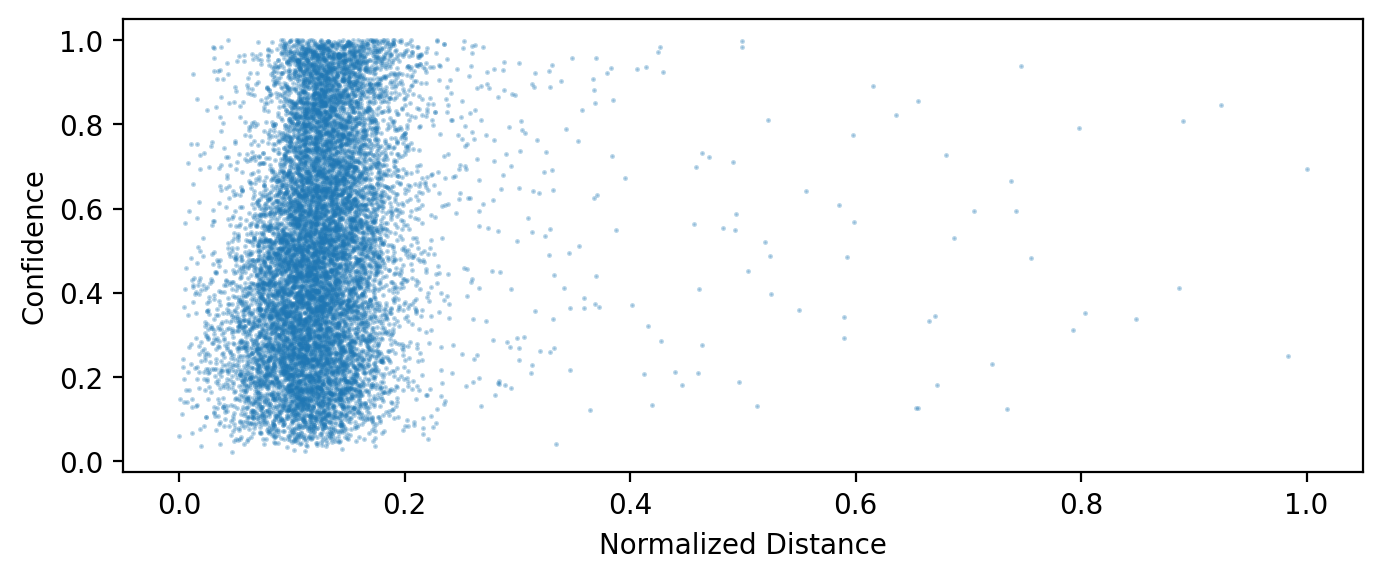

In [145]:
plt.figure(figsize = [8,3], dpi = 200)
plt.scatter(df2['Dis'], df2['Confidence'],alpha = 0.3,marker = 'o', s = 0.6)
plt.xlabel('Normalized Distance')
plt.ylabel('Confidence')

#### Plot similarity with C Perplexity

Text(0, 0.5, 'C Perplexity')

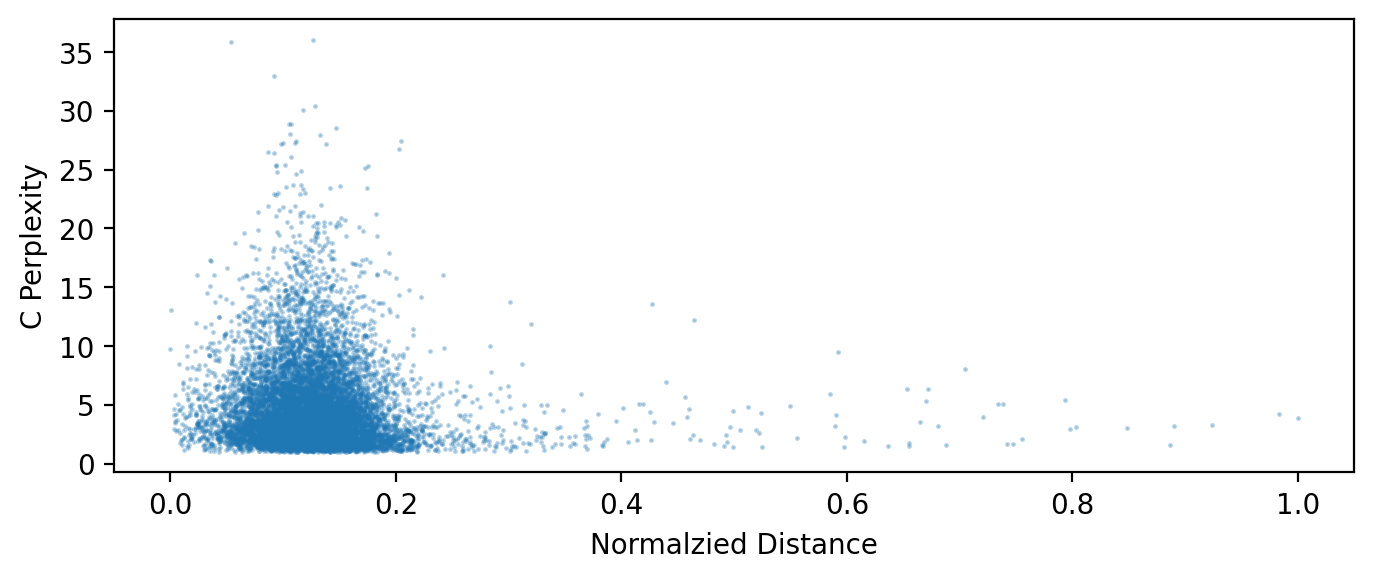

In [146]:
plt.figure(figsize = [8,3], dpi = 200)
plt.scatter(df2['Dis'], df2['C_PERPLEXITY'],alpha = 0.3,marker = 'o', s = 0.6)
plt.xlabel('Normalzied Distance')
plt.ylabel('C Perplexity')

- A large proportion of wrong predicitons have charatersitics of large distance between e_t and e_p

- Can say that wrong attention is the main reason of wrong prediciton.

Text(0, 0.5, 'C Perplexity')

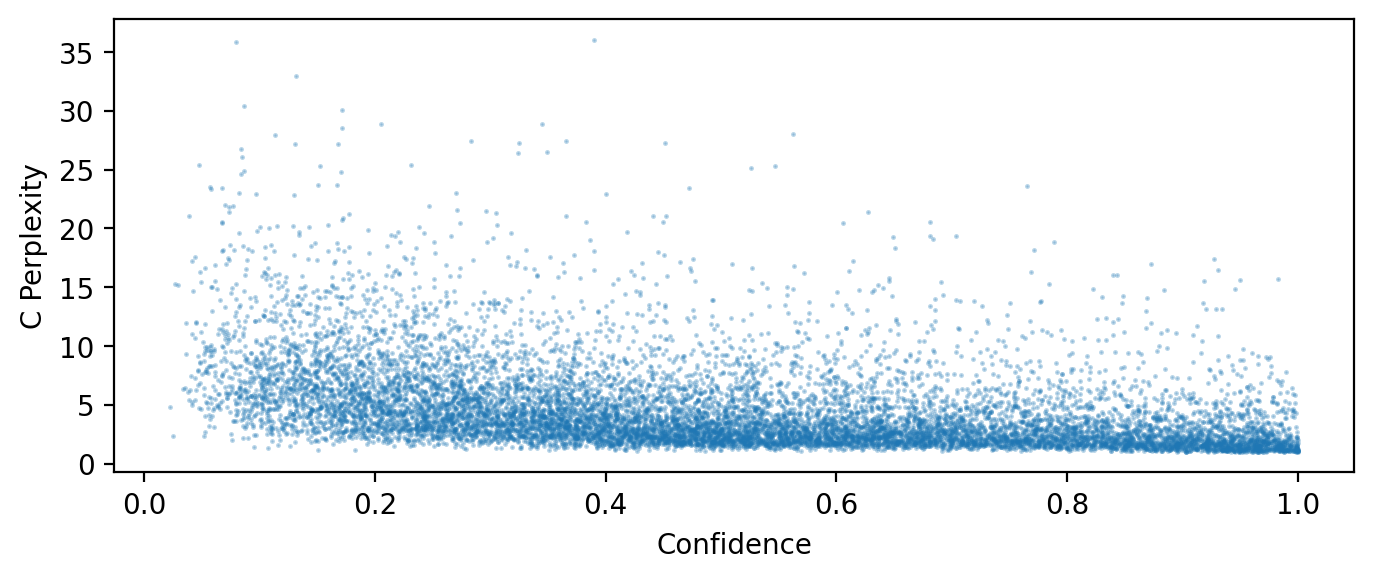

In [155]:
plt.figure(figsize = [8,3], dpi = 200)
plt.scatter(df2['Confidence'], df2['C_PERPLEXITY'],alpha = 0.3,marker = 'o', s = 0.6)
plt.xlabel('Confidence')
plt.ylabel('C Perplexity')